<a href="https://colab.research.google.com/github/lorenzkuhn/advi/blob/main/ARD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pyro-ppl 

     |████████████████████████████████| 718 kB 13.3 MB/s 
     |████████████████████████████████| 750.6 MB 13 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [2]:
import torch
import pyro
from torch import nn
from pyro.nn import PyroModule
from pyro.nn import PyroSample
import pyro.distributions as dist
import pandas as pd
import numpy as np
from pyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

In [3]:
def model(x, y=None):
      num_features = x.shape[1]

      alpha = pyro.sample('alpha', dist.Gamma(torch.tensor([1.0]), torch.tensor([1.0])).expand([num_features]).to_event(1))
      one_over_sqrt_alpha = 1/torch.sqrt(alpha)

      sigma2 = pyro.sample('sigma2', dist.InverseGamma(torch.tensor([1.0]), torch.tensor([1.0])))
      sigma = torch.sqrt(sigma2)

      beta = pyro.sample('beta', dist.Normal(torch.tensor([0.0]), sigma*one_over_sqrt_alpha).expand([num_features]).to_event(1))

      mean = torch.matmul(x, beta)

      with pyro.plate("data", x.shape[0]):
          
          # Assume our expected mean comes from a normal distribution with the mean which
          # depends on the linear combination, and a standard deviatin "sigma"
          outcome_dist = dist.Normal(mean, sigma)
          
          # Condition the expected mean on the observed target y
          observation = pyro.sample("obs", outcome_dist, obs=y)

In [4]:
# Making training data
def make_training_data(num_samples, dims, sigma, mu=0):
  """
  Creates training data when half of the regressors are 0
  """
  x = np.random.randn(num_samples, dims).astype(np.float64)
  w = sigma * np.random.randn(1,dims).astype(np.float64)
  noise = np.random.randn(num_samples).astype(np.float64)
  noise = 0
  w[:,:int(dims/2)] = 0.
  y = np.matmul(x, w.T) + (noise/2) + mu

  y = torch.tensor(y, dtype = torch.float)
  x = torch.tensor(x, dtype = torch.float)
  return y, x, w


def sep_training_test(y,x,test):
  y_train = y[test:,:]
  x_train = x[test:,:]
  
  y_test = y[:test,:]
  x_test = x[:test,:]
  return y_train, y_test, x_train, x_test

num_features = 250

y, x, w = make_training_data(11000, num_features, 10, mu=0)
y_train, y_test, x_train, x_test = sep_training_test(y,x,1000)

In [21]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide import AutoContinuous
from pyro.infer import SVI, Trace_ELBO

guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 1})
adaprop = pyro.optim.AdagradRMSProp(dict())

svi = SVI(model, guide, adaprop, loss=Trace_ELBO())

In [22]:
from scipy.stats import norm as NormalDist
import time

pyro.clear_param_store()
num_iterations = 3000
step_ids = []
step_time = []
average_log_predictives = []
mse_loss = nn.MSELoss()

start = time.time()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_train, y_train.squeeze())
    #step_ids.append(j)       

    if j % 100 == 0:
      t0_waste = time.time()
      num_samples = 100
      predictive_svi = Predictive(model, guide=guide, num_samples=num_samples)

      train_predictions = predictive_svi(x_train, None)
      test_predictions = predictive_svi(x_test, None)
      train_obs = train_predictions['obs']
      test_obs = test_predictions['obs']

      average_train_log_mse = torch.log(mse_loss(train_obs, torch.tile(np.squeeze(y_train), (len(train_obs), 1))))
      average_test_log_mse = torch.log(mse_loss(test_obs, torch.tile(np.squeeze(y_test), (len(test_obs), 1))))
  
      step_ids.append(j)
      print("[iteration %04d] loss: %.4f" % (j + 1, average_test_log_mse))
      t1_waste = time.time()
      step_time.append(time.time()-start-(t1_waste-t0_waste))
      average_log_predictives.append(average_test_log_mse)

[iteration 0001] loss: 9.3453
[iteration 0101] loss: 8.4970
[iteration 0201] loss: 7.9857
[iteration 0301] loss: 5.3169
[iteration 0401] loss: 0.1289
[iteration 0501] loss: -0.9651
[iteration 0601] loss: -1.3800
[iteration 0701] loss: -1.4392
[iteration 0801] loss: -1.7201
[iteration 0901] loss: -1.7257
[iteration 1001] loss: -1.8665
[iteration 1101] loss: -2.1612
[iteration 1201] loss: -1.9796
[iteration 1301] loss: -2.2091
[iteration 1401] loss: -2.1167
[iteration 1501] loss: -2.3662
[iteration 1601] loss: -2.2647
[iteration 1701] loss: -2.3659
[iteration 1801] loss: -2.5853
[iteration 1901] loss: -2.7071
[iteration 2001] loss: -2.5852
[iteration 2101] loss: -2.7548
[iteration 2201] loss: -2.7540
[iteration 2301] loss: -2.7488
[iteration 2401] loss: -2.7656
[iteration 2501] loss: -2.8179
[iteration 2601] loss: -3.0236
[iteration 2701] loss: -2.9563
[iteration 2801] loss: -2.8041
[iteration 2901] loss: -2.8067


Text(0, 0.5, 'Average log predictive MSE')

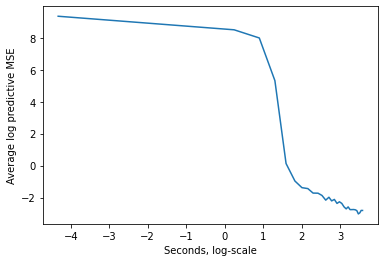

In [23]:
plt.plot(np.log(step_time), np.array(average_log_predictives))
plt.xlabel("Seconds, log-scale")
plt.ylabel("Average log predictive MSE")

In [ ]:
from pyro.infer import MCMC, NUTS, HMC
pyro.clear_param_store()
import logging

output = pd.DataFrame(columns = ["run_id", "t", "num_samples", "test_accuracy"])

num_runs = 10
max_samples = 500

for i in range(5):
  for run_id in range(max_samples/50):
    nuts_kernel = NUTS(model,
                      max_tree_depth = 14)

    mcmc = MCMC(
            nuts_kernel,
            num_samples=50*(i+1),
            warmup_steps=20,
            disable_progbar=True
    ) 

    start = time.time()
    mcmc.run(x_train, y_train.squeeze())
    end = time.time()

    nuts_kernel.end_warmup()

    samples = mcmc.get_samples()
    mcmc_predictive = Predictive(model, samples)

    test_obs = mcmc_predictive(x_test, None)['obs']
    train_obs = mcmc_predictive(x_train, None)['obs']

    average_test_log_accuracy = torch.mean(torch.log(mse_loss(test_obs, torch.tile(np.squeeze(y_test), (len(test_obs), 1)))))
    average_train_log_accuracy = torch.mean(torch.log(mse_loss(train_obs, torch.tile(np.squeeze(y_train), (len(train_obs), 1)))))

    output_iter = {"run_id":run_id,
                  "t":end-start,
                  "num_samples":50*(i+1), 
                  "test_accuracy":average_test_log_accuracy.detach().numpy()}

    output = output.append(output_iter, ignore_index = True)

    print('Run id: {}'.format(run_id))
    print('Num samples: {}'.format(50*(i+1)))


Run id: 0
Num samples: 50
Run id: 1
Num samples: 50
Run id: 2
Num samples: 50
Run id: 3
Num samples: 50
Run id: 4
Num samples: 50
Run id: 5
Num samples: 50
Run id: 6
Num samples: 50
Run id: 7
Num samples: 50
Run id: 8
Num samples: 50
Run id: 9
Num samples: 50
Run id: 0
Num samples: 100
Run id: 1
Num samples: 100
Run id: 2
Num samples: 100
Run id: 3
Num samples: 100
Run id: 4
Num samples: 100
Run id: 5
Num samples: 100
Run id: 6
Num samples: 100
Run id: 7
Num samples: 100
Run id: 8
Num samples: 100
Run id: 9
Num samples: 100
Run id: 0
Num samples: 150
Run id: 1
Num samples: 150
Run id: 2
Num samples: 150
Run id: 3
Num samples: 150
Run id: 4
Num samples: 150
Run id: 5
Num samples: 150
Run id: 6
Num samples: 150
Run id: 7
Num samples: 150
Run id: 8
Num samples: 150
Run id: 9
Num samples: 150
Run id: 0
Num samples: 200
Run id: 1
Num samples: 200
Run id: 2
Num samples: 200
Run id: 3
Num samples: 200
Run id: 4
Num samples: 200
Run id: 5
Num samples: 200


In [146]:
output["t_rounded"] = output['t'].round(0)
output[['t_rounded', 'test_accuracy']].groupby("t_rounded").mean()

Text(0, 0.5, 'Average log predictive MSE')

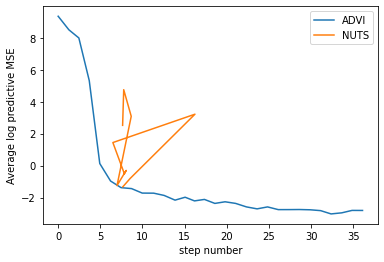

In [26]:
plt.plot(np.array(step_time), np.array(average_log_predictives), label = 'ADVI')
plt.plot(np.array(mcmc_step_time), mcmc_average_test_log_accuracy, label='NUTS')
plt.legend()
plt.xlabel("step number")
plt.ylabel("Average log predictive MSE")


In [25]:
import pyro.poutine as poutine

def make_log_joint(model):
    def _log_joint(cond_data, *args, **kwargs):
        conditioned_model = poutine.condition(model, data=cond_data)
        trace = poutine.trace(conditioned_model).get_trace(*args, **kwargs)
        return trace.log_prob_sum()
    return _log_joint

scale_log_joint = make_log_joint(model)

alpha = torch.mean(samples['alpha'], dim = 0)
sigma2 = torch.mean(samples['sigma2'], dim = 0)
beta = torch.mean(samples['beta'], dim = 0)

print(scale_log_joint({"alpha": alpha, 
                       "sigma2": sigma2,
                       "beta": beta}, x_test, y_test)/x_test.shape[0])


tensor(-10071.6641)


In [169]:
x_train.shape

torch.Size([80, 10])

In [303]:
w

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,  -6.54631337, -12.37945198, -17.52719374,
        -11.93596   ,  14.22016424]])

Text(0, 0.5, 'Average log predictive MSE')

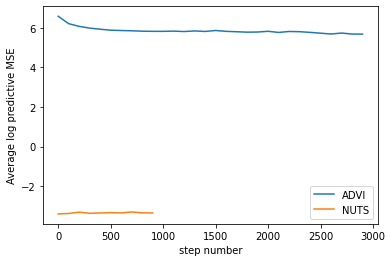

In [306]:
plt.plot(step_ids, average_log_predictives, label='ADVI')
plt.plot(np.array(mcmc_step_ids), mcmc_average_test_log_accuracy, label='NUTS')
plt.legend()
plt.xlabel("step number")
plt.ylabel("Average log predictive MSE")


## Subsampling behaviour of approximate inference methods

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=10)

In [ ]:
nuts_kernel = NUTS(model, jit_compile=False, step_size=0.5)
num_samples = 200

mcmc = MCMC(
    nuts_kernel,
    num_samples=num_samples,
    warmup_steps=0,
    num_chains=1,
)


mcmc_step_ids = []
mcmc_average_test_log_accuracy = []

mse_loss = torch.nn.MSELoss()


for i in range(1):

  for x, y in dataloader:
    mcmc.run(x, y)
    #mcmc.summary(prob=0.5)
    #diagnostics = mcmc.diagnostics()

    samples = mcmc.get_samples()
    mcmc_predictive = Predictive(model, samples)
    
    test_obs = mcmc_predictive(x_test, None)['obs']
    train_obs = mcmc_predictive(x_train, None)['obs']


    average_test_log_accuracy = torch.mean(torch.log(mse_loss(test_obs, torch.tile(np.squeeze(y_test), (len(test_obs), 1)))))
    average_train_log_accuracy = torch.mean(torch.log(mse_loss(train_obs, torch.tile(np.squeeze(y_train), (len(train_obs), 1)))))
    print(average_train_log_accuracy)
    print(average_test_log_accuracy)
    mcmc_step_ids.append(i*num_samples)
    mcmc_average_test_log_accuracy.append(average_test_log_accuracy)

Sample: 100%|██████████| 200/200 [00:01, 175.46it/s, step size=1.25e-01, acc. prob=0.247]


tensor(-0.1714)
tensor(-0.1489)


Sample: 100%|██████████| 200/200 [00:01, 108.14it/s, step size=6.25e-02, acc. prob=0.848]


tensor(-0.2325)
tensor(-0.2333)


Sample: 100%|██████████| 200/200 [00:02, 79.67it/s, step size=6.25e-02, acc. prob=0.887]


tensor(-0.1615)
tensor(-0.1059)


Sample: 100%|██████████| 200/200 [00:02, 87.94it/s, step size=6.25e-02, acc. prob=0.865]


tensor(-0.1586)
tensor(-0.1431)


Sample: 100%|██████████| 200/200 [00:01, 135.96it/s, step size=1.25e-01, acc. prob=0.645]


tensor(-0.1388)
tensor(-0.0518)


Sample: 100%|██████████| 200/200 [00:01, 140.59it/s, step size=1.25e-01, acc. prob=0.426]


tensor(-0.1661)
tensor(-0.1471)


Sample: 100%|██████████| 200/200 [00:02, 85.29it/s, step size=6.25e-02, acc. prob=0.855]


tensor(-0.1983)
tensor(-0.1781)


Sample: 100%|██████████| 200/200 [00:02, 81.16it/s, step size=6.25e-02, acc. prob=0.866]


tensor(-0.1314)
tensor(-0.0330)


Sample: 100%|██████████| 200/200 [00:01, 101.04it/s, step size=6.25e-02, acc. prob=0.883]


tensor(-0.1479)
tensor(-0.1494)


Sample: 100%|██████████| 200/200 [00:01, 139.08it/s, step size=1.25e-01, acc. prob=0.266]


tensor(-0.1899)
tensor(-0.1921)


Sample: 100%|██████████| 200/200 [00:01, 137.44it/s, step size=1.25e-01, acc. prob=0.184]


tensor(-0.1770)
tensor(-0.2099)


Sample: 100%|██████████| 200/200 [00:00, 270.98it/s, step size=1.25e-01, acc. prob=0.006]


tensor(1.0284)
tensor(0.9391)


Sample: 100%|██████████| 200/200 [00:02, 87.22it/s, step size=6.25e-02, acc. prob=0.876]


tensor(-0.1286)
tensor(-0.1626)


Sample: 100%|██████████| 200/200 [00:01, 116.65it/s, step size=6.25e-02, acc. prob=0.854]


tensor(-0.2601)
tensor(-0.2652)


Sample: 100%|██████████| 200/200 [00:01, 190.86it/s, step size=1.25e-01, acc. prob=0.107]


tensor(0.0139)
tensor(0.0307)


Sample: 100%|██████████| 200/200 [00:01, 109.62it/s, step size=1.25e-01, acc. prob=0.170]


tensor(0.2815)
tensor(0.3182)


Sample: 100%|██████████| 200/200 [00:01, 143.97it/s, step size=1.25e-01, acc. prob=0.165]


tensor(-0.1020)
tensor(-0.0704)


Sample: 100%|██████████| 200/200 [00:02, 82.49it/s, step size=6.25e-02, acc. prob=0.875]


tensor(-0.2214)
tensor(-0.2169)


Sample: 100%|██████████| 200/200 [00:01, 102.22it/s, step size=6.25e-02, acc. prob=0.851]


tensor(-0.2197)
tensor(-0.1875)


Sample: 100%|██████████| 200/200 [00:01, 103.37it/s, step size=6.25e-02, acc. prob=0.865]


tensor(-0.0831)
tensor(-0.0701)


Sample: 100%|██████████| 200/200 [00:01, 105.58it/s, step size=6.25e-02, acc. prob=0.837]


tensor(-0.2235)
tensor(-0.2438)


Sample: 100%|██████████| 200/200 [00:01, 174.68it/s, step size=1.25e-01, acc. prob=0.133]


tensor(-0.1347)
tensor(-0.1395)


Sample: 100%|██████████| 200/200 [00:01, 148.44it/s, step size=1.25e-01, acc. prob=0.272]


tensor(-0.0672)
tensor(-0.0484)


Sample: 100%|██████████| 200/200 [00:02, 94.06it/s, step size=6.25e-02, acc. prob=0.847]


tensor(-0.1842)
tensor(-0.1440)


Sample: 100%|██████████| 200/200 [00:01, 140.96it/s, step size=1.25e-01, acc. prob=0.272]


tensor(-0.2107)
tensor(-0.2506)


Sample: 100%|██████████| 200/200 [00:01, 139.87it/s, step size=1.25e-01, acc. prob=0.580]


tensor(-0.1926)
tensor(-0.1841)


Sample: 100%|██████████| 200/200 [00:02, 80.08it/s, step size=6.25e-02, acc. prob=0.917]


tensor(-0.1935)
tensor(-0.1789)


Sample: 100%|██████████| 200/200 [00:02, 92.44it/s, step size=6.25e-02, acc. prob=0.797]


tensor(-0.1907)
tensor(-0.2047)


Sample: 100%|██████████| 200/200 [00:02, 84.81it/s, step size=6.25e-02, acc. prob=0.908]


tensor(-0.2174)
tensor(-0.2079)


Sample: 100%|██████████| 200/200 [00:01, 183.38it/s, step size=1.25e-01, acc. prob=0.092]


tensor(-0.1879)
tensor(-0.2052)


Sample: 100%|██████████| 200/200 [00:01, 115.57it/s, step size=6.25e-02, acc. prob=0.808]


tensor(-0.2216)
tensor(-0.1941)


Sample: 100%|██████████| 200/200 [00:01, 140.43it/s, step size=1.25e-01, acc. prob=0.427]


tensor(-0.1767)
tensor(-0.1180)


Sample: 100%|██████████| 200/200 [00:01, 138.81it/s, step size=1.25e-01, acc. prob=0.453]


tensor(-0.1612)
tensor(-0.1485)


Sample: 100%|██████████| 200/200 [00:00, 225.44it/s, step size=1.25e-01, acc. prob=0.115]


tensor(-0.0572)
tensor(-0.0471)


Sample: 100%|██████████| 200/200 [00:02, 98.38it/s, step size=6.25e-02, acc. prob=0.832]


tensor(-0.2307)
tensor(-0.2536)


Sample: 100%|██████████| 200/200 [00:01, 181.37it/s, step size=1.25e-01, acc. prob=0.115]


tensor(-0.2263)
tensor(-0.2446)


Sample: 100%|██████████| 200/200 [00:01, 182.49it/s, step size=1.25e-01, acc. prob=0.445]


tensor(-0.2081)
tensor(-0.2019)


Sample: 100%|██████████| 200/200 [00:01, 100.63it/s, step size=6.25e-02, acc. prob=0.879]


tensor(-0.1909)
tensor(-0.1993)


Sample: 100%|██████████| 200/200 [00:00, 255.86it/s, step size=1.25e-01, acc. prob=0.007]


tensor(0.8414)
tensor(1.0231)


Sample: 100%|██████████| 200/200 [00:02, 69.17it/s, step size=6.25e-02, acc. prob=0.867]


tensor(-0.1530)
tensor(-0.1710)


Sample: 100%|██████████| 200/200 [00:01, 116.85it/s, step size=1.25e-01, acc. prob=0.301]


tensor(-0.1387)
tensor(-0.1403)


Sample: 100%|██████████| 200/200 [00:01, 142.27it/s, step size=1.25e-01, acc. prob=0.207]


tensor(-0.1995)
tensor(-0.1839)


Sample: 100%|██████████| 200/200 [00:02, 93.55it/s, step size=6.25e-02, acc. prob=0.822]


tensor(-0.1988)
tensor(-0.1655)


Sample: 100%|██████████| 200/200 [00:01, 175.04it/s, step size=1.25e-01, acc. prob=0.445]


tensor(-0.2174)
tensor(-0.2118)


Sample: 100%|██████████| 200/200 [00:01, 147.93it/s, step size=1.25e-01, acc. prob=0.450]


tensor(-0.2221)
tensor(-0.2241)


Sample: 100%|██████████| 200/200 [00:02, 70.80it/s, step size=6.25e-02, acc. prob=0.810]


tensor(-0.1302)
tensor(-0.0871)


Sample: 100%|██████████| 200/200 [00:01, 141.84it/s, step size=1.25e-01, acc. prob=0.274]


tensor(-0.1805)
tensor(-0.1517)


Sample: 100%|██████████| 200/200 [00:01, 105.66it/s, step size=6.25e-02, acc. prob=0.781]


tensor(-0.1909)
tensor(-0.1683)


Sample: 100%|██████████| 200/200 [00:01, 148.01it/s, step size=1.25e-01, acc. prob=0.510]


tensor(-0.2202)
tensor(-0.1836)


Sample: 100%|██████████| 200/200 [00:00, 244.97it/s, step size=1.25e-01, acc. prob=0.012]


tensor(0.6077)
tensor(0.5787)


Sample: 100%|██████████| 200/200 [00:00, 289.91it/s, step size=1.25e-01, acc. prob=0.003]


tensor(0.9432)
tensor(1.1361)


Sample: 100%|██████████| 200/200 [00:01, 168.59it/s, step size=1.25e-01, acc. prob=0.503]


tensor(-0.1931)
tensor(-0.1897)


Sample: 100%|██████████| 200/200 [00:00, 208.28it/s, step size=1.25e-01, acc. prob=0.005]


tensor(0.3146)
tensor(0.3299)


Sample: 100%|██████████| 200/200 [00:01, 164.95it/s, step size=1.25e-01, acc. prob=0.470]


tensor(-0.2157)
tensor(-0.2550)


Sample: 100%|██████████| 200/200 [00:02, 69.07it/s, step size=6.25e-02, acc. prob=0.880]


tensor(-0.0224)
tensor(-0.0794)


Sample: 100%|██████████| 200/200 [00:01, 144.91it/s, step size=1.25e-01, acc. prob=0.229]


tensor(-0.1732)
tensor(-0.2111)


Sample: 100%|██████████| 200/200 [00:01, 134.96it/s, step size=1.25e-01, acc. prob=0.192]


tensor(-0.1674)
tensor(-0.1626)


Sample: 100%|██████████| 200/200 [00:01, 125.19it/s, step size=1.25e-01, acc. prob=0.399]


tensor(-0.2001)
tensor(-0.1409)


Sample: 100%|██████████| 200/200 [00:01, 154.15it/s, step size=1.25e-01, acc. prob=0.548]


tensor(-0.2016)
tensor(-0.2000)


Sample: 100%|██████████| 200/200 [00:00, 250.64it/s, step size=1.25e-01, acc. prob=0.006]


tensor(0.6532)
tensor(0.7039)


Sample: 100%|██████████| 200/200 [00:01, 118.46it/s, step size=1.25e-01, acc. prob=0.317]


tensor(-0.1333)
tensor(-0.1333)


Sample: 100%|██████████| 200/200 [00:02, 70.89it/s, step size=6.25e-02, acc. prob=0.867]


tensor(-0.1789)
tensor(-0.1950)


Sample: 100%|██████████| 200/200 [00:02, 87.42it/s, step size=6.25e-02, acc. prob=0.869]


tensor(-0.1777)
tensor(-0.1295)


Sample: 100%|██████████| 200/200 [00:02, 95.83it/s, step size=6.25e-02, acc. prob=0.872]


tensor(-0.1696)
tensor(-0.1543)


Sample: 100%|██████████| 200/200 [00:01, 130.77it/s, step size=1.25e-01, acc. prob=0.596]


tensor(-0.1358)
tensor(-0.1025)


Sample: 100%|██████████| 200/200 [00:02, 80.29it/s, step size=6.25e-02, acc. prob=0.889]


tensor(-0.1634)
tensor(-0.1567)


Sample: 100%|██████████| 200/200 [00:01, 177.62it/s, step size=1.25e-01, acc. prob=0.212]


tensor(-0.2176)
tensor(-0.2000)


Sample: 100%|██████████| 200/200 [00:01, 118.33it/s, step size=1.25e-01, acc. prob=0.439]


tensor(-0.1627)
tensor(-0.1014)


Sample: 100%|██████████| 200/200 [00:01, 145.86it/s, step size=1.25e-01, acc. prob=0.205]


tensor(-0.0456)
tensor(0.0198)


Sample: 100%|██████████| 200/200 [00:01, 130.45it/s, step size=1.25e-01, acc. prob=0.511]


tensor(-0.1937)
tensor(-0.1848)


Sample: 100%|██████████| 200/200 [00:02, 86.59it/s, step size=6.25e-02, acc. prob=0.866]


tensor(-0.1766)
tensor(-0.2147)


Sample: 100%|██████████| 200/200 [00:02, 74.00it/s, step size=6.25e-02, acc. prob=0.869]


tensor(-0.1146)
tensor(-0.0574)


Sample: 100%|██████████| 200/200 [00:01, 138.97it/s, step size=1.25e-01, acc. prob=0.437]


tensor(-0.2009)
tensor(-0.1969)


Sample: 100%|██████████| 200/200 [00:01, 102.52it/s, step size=6.25e-02, acc. prob=0.823]


tensor(-0.2043)
tensor(-0.1873)


Sample: 100%|██████████| 200/200 [00:02, 74.71it/s, step size=6.25e-02, acc. prob=0.879]


tensor(-0.0968)
tensor(-0.1133)


Sample: 100%|██████████| 200/200 [00:02, 75.78it/s, step size=6.25e-02, acc. prob=0.888]


tensor(-0.1427)
tensor(-0.1171)


Sample: 100%|██████████| 200/200 [00:02, 83.37it/s, step size=6.25e-02, acc. prob=0.859]


tensor(-0.1272)
tensor(-0.1623)


Sample: 100%|██████████| 200/200 [00:01, 101.24it/s, step size=6.25e-02, acc. prob=0.871]


tensor(-0.2463)
tensor(-0.2571)


Sample: 100%|██████████| 200/200 [00:02, 80.99it/s, step size=6.25e-02, acc. prob=0.867]


tensor(-0.0491)
tensor(-0.0384)


Sample: 100%|██████████| 200/200 [00:00, 226.71it/s, step size=1.25e-01, acc. prob=0.009]


tensor(0.1706)
tensor(0.2255)


Sample: 100%|██████████| 200/200 [00:01, 165.28it/s, step size=1.25e-01, acc. prob=0.234]


tensor(-0.0650)
tensor(-0.0115)


Sample: 100%|██████████| 200/200 [00:01, 147.89it/s, step size=1.25e-01, acc. prob=0.146]


tensor(0.7558)
tensor(0.8766)


Sample: 100%|██████████| 200/200 [00:00, 283.58it/s, step size=1.25e-01, acc. prob=0.005]


tensor(0.8398)
tensor(0.8573)


Sample: 100%|██████████| 200/200 [00:02, 94.88it/s, step size=6.25e-02, acc. prob=0.838]


tensor(-0.1918)
tensor(-0.1989)


Sample: 100%|██████████| 200/200 [00:01, 119.51it/s, step size=6.25e-02, acc. prob=0.859]


tensor(-0.2600)
tensor(-0.2907)


Sample: 100%|██████████| 200/200 [00:00, 289.53it/s, step size=1.25e-01, acc. prob=0.008]


tensor(0.6762)
tensor(0.6877)


Sample: 100%|██████████| 200/200 [00:01, 112.71it/s, step size=6.25e-02, acc. prob=0.844]


tensor(-0.2004)
tensor(-0.2013)


Sample: 100%|██████████| 200/200 [00:02, 79.23it/s, step size=6.25e-02, acc. prob=0.890]


tensor(-0.1414)
tensor(-0.1460)


Sample: 100%|██████████| 200/200 [00:03, 65.04it/s, step size=6.25e-02, acc. prob=0.875]


tensor(-0.1166)
tensor(-0.0987)


Sample: 100%|██████████| 200/200 [00:02, 96.81it/s, step size=6.25e-02, acc. prob=0.876]


tensor(-0.1718)
tensor(-0.1694)


Sample: 100%|██████████| 200/200 [00:01, 107.93it/s, step size=1.25e-01, acc. prob=0.627]


tensor(-0.0479)
tensor(-0.0327)


Sample: 100%|██████████| 200/200 [00:02, 85.00it/s, step size=6.25e-02, acc. prob=0.818]


tensor(-0.1894)
tensor(-0.1537)


Sample: 100%|██████████| 200/200 [00:02, 80.62it/s, step size=6.25e-02, acc. prob=0.887]


tensor(-0.1763)
tensor(-0.1408)


Sample: 100%|██████████| 200/200 [00:02, 99.80it/s, step size=6.25e-02, acc. prob=0.894] 


tensor(-0.2388)
tensor(-0.2801)


Sample: 100%|██████████| 200/200 [00:01, 100.15it/s, step size=6.25e-02, acc. prob=0.884]


tensor(-0.2162)
tensor(-0.2485)


Sample: 100%|██████████| 200/200 [00:01, 167.31it/s, step size=1.25e-01, acc. prob=0.267]


tensor(-0.1615)
tensor(-0.1573)


Sample: 100%|██████████| 200/200 [00:01, 104.63it/s, step size=6.25e-02, acc. prob=0.856]


tensor(-0.2196)
tensor(-0.1743)


Sample: 100%|██████████| 200/200 [00:01, 111.43it/s, step size=6.25e-02, acc. prob=0.832]


tensor(-0.2270)
tensor(-0.2217)
